# Melanoma Detection Project

## Project Overview
The dataset focused on melanoma skin cancer comprises 10,000 images and is instrumental for training deep learning models aimed at the accurate identification of this severe form of cancer. Early detection is crucial, as it significantly increases the chances of successful treatment, potentially saving many lives. The dataset is split into two parts: 9,600 images are designated for training purposes, while the remaining 1,000 images are set aside for model evaluation.

## Objectives
- To develop a convolutional neural network (CNN) that accurately classifies skin lesions as malignant or benign.
- To evaluate the model's performance using accuracy, precision, recall, and F1-score.




## Installing Dependencies
Below are the Python libraries required for this project:

In [2]:
import os
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive/')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} device.')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Using cpu device.


## Data Description and Loading

The dataset comprises dermatoscopic images divided into training and testing sets. Each set contains subdirectories labeled 'malignant' and 'benign', representing the respective classes of skin lesions.

### Setting up Data Loaders

To process the images, we will use `torchvision`'s `datasets.ImageFolder` along with data loaders from PyTorch to handle these images efficiently during training.


In [3]:
# Define the transformation to resize the images and convert them to tensors
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resizes all images to 256x256 pixels
    transforms.ToTensor()           # Converts the images to PyTorch tensors
])

# Define paths to the dataset directories
train_dir = '/content/drive/My Drive/BIT_project/MelanomaDetection/data/train'
test_dir = '/content/drive/My Drive/BIT_project/MelanomaDetection/data/test'

# Load the datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create the data loaders for training and testing
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

## Exploratory Data Analysis (EDA)

Given the image-based data, we can explore sample images to understand the dataset visually.


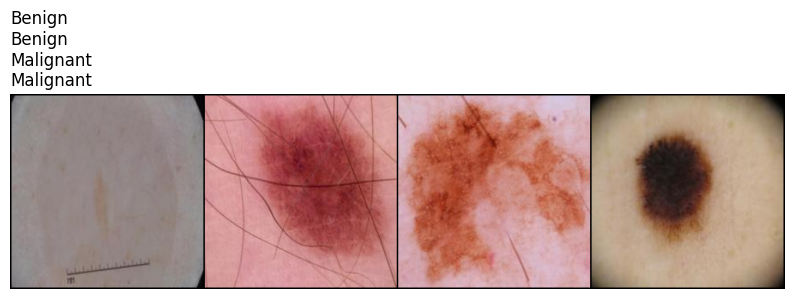

In [18]:
# Function to show an image along with its labels
def imshow(img, labels, classes):
    """Function to show an image along with its labels."""
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # transpose the dimensions to display properly
    plt.axis('off')  # Turn off axis numbers and ticks

    # Set titles for each image in the batch
    titles = [classes[label] for label in labels]
    plt.title("\n".join(titles), loc='left', fontsize=12)  # Use newline to separate titles clearly

# Get a batch of training images
images, labels = next(iter(train_loader))

# Display the images with titles
imshow(torchvision.utils.make_grid(images, nrow=4), labels, train_dataset.classes)

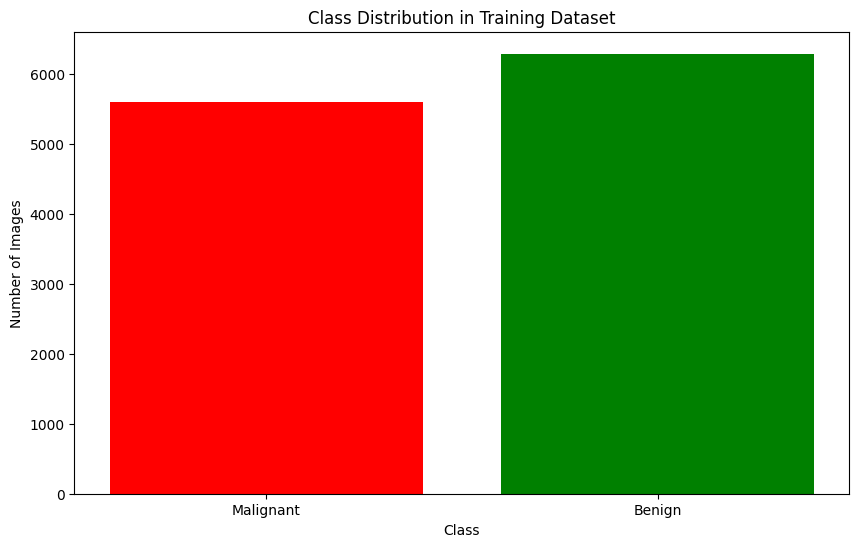

In [6]:
train_malignant_dir = '/content/drive/My Drive/BIT_project/MelanomaDetection/data/train/Malignant'
train_benign_dir = '/content/drive/My Drive/BIT_project/MelanomaDetection/data/train/Benign'

# Counting the number of images in each class directory
num_malignant = len(os.listdir(train_malignant_dir))
num_benign = len(os.listdir(train_benign_dir))

class_names = ['Malignant', 'Benign']
class_counts = [num_malignant, num_benign]

# Plotting the class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts, color=['red', 'green'])
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


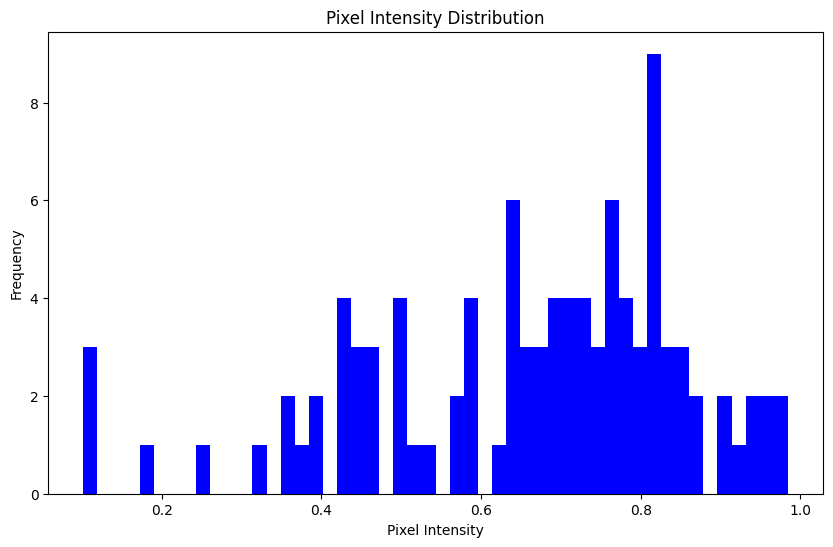

In [5]:
sample_size = 100

sample_images, _ = next(iter(train_loader))  # Get one batch
sample_images = sample_images.numpy()  # Convert to NumPy array

# Select a random sample of pixels from all channels
pixel_values = sample_images.flatten()[np.random.choice(sample_images.size, sample_size)]

# Plotting the histogram of pixel values
plt.figure(figsize=(10, 6))
plt.hist(pixel_values, bins=50, color='blue')
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

## Experiment 1: SimpleCNN
First we will experiment with a simple cnn to see the results and get a baseline. After that, the goal will be to improve as we experiment with other architectures and tuning hyperparameters.

In [29]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.25)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 64 * 64, 256)
        self.act3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = x.view(-1, 64 * 64 * 64)
        x = self.dropout3(self.act3(self.fc1(x)))
        x = self.fc2(x)
        return x

# Define data augmentations and transformations
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets with applied transformations
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)

# Create DataLoaders
total_train_samples = len(train_dataset)
train_size = int(0.8 * total_train_samples)
val_size = total_train_samples - train_size

split_train_dataset, split_val_dataset = random_split(train_dataset, [train_size, val_size])

# Now use the correct datasets for creating dataloaders
train_loader = DataLoader(split_train_dataset, batch_size=64, num_workers=2, shuffle=True)
val_loader = DataLoader(split_val_dataset, batch_size=64, num_workers=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, num_workers =2, shuffle=False)



def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=5):
    best_val_loss = float('inf')
    best_model_sd = None  # Save the best model state dict in memory
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)
                total_val_loss += loss.item()

        train_loss = total_train_loss / len(train_loader)
        val_loss = total_val_loss / len(val_loader)
        print(f'Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_sd = model.state_dict()  # Update the best model state dict
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Stopping early at epoch {epoch+1}")
            break

    if best_model_sd:
        model.load_state_dict(best_model_sd)  # Load the best model from memory
    return model



# Initialize the model
model = SimpleCNN().to(device)


# Setup optimizer with found learning rate
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Train the model with early stopping
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, device=device, num_epochs=50, patience=5)



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1: Train Loss = 0.5435, Val Loss = 0.4198
Epoch 2: Train Loss = 0.4334, Val Loss = 0.4018
Epoch 3: Train Loss = 0.4218, Val Loss = 0.4292
Epoch 4: Train Loss = 0.4089, Val Loss = 0.3925
Epoch 5: Train Loss = 0.4089, Val Loss = 0.3964
Epoch 6: Train Loss = 0.3976, Val Loss = 0.3755
Epoch 7: Train Loss = 0.3904, Val Loss = 0.3848
Epoch 8: Train Loss = 0.3874, Val Loss = 0.3974
Epoch 9: Train Loss = 0.3793, Val Loss = 0.3689
Epoch 10: Train Loss = 0.3786, Val Loss = 0.3688
Epoch 11: Train Loss = 0.3720, Val Loss = 0.3696
Epoch 12: Train Loss = 0.3636, Val Loss = 0.3557
Epoch 13: Train Loss = 0.3678, Val Loss = 0.3623
Epoch 14: Train Loss = 0.3661, Val Loss = 0.3586
Epoch 15: Train Loss = 0.3608, Val Loss = 0.3532
Epoch 16: Train Loss = 0.3552, Val Loss = 0.3550
Epoch 17: Train Loss = 0.3529, Val Loss = 0.3530
Epoch 18: Train Loss = 0.3516, Val Loss = 0.3495
Epoch 19: Train Loss = 0.3521, Val Loss = 0.3420
Epoch 20: Train Loss = 0.3545, Val Loss = 0.3394
Epoch 21: Train Loss = 0.3527

In [30]:
# Function to evaluate the model on the test set
def evaluate_model(model, test_loader, device):
    model.eval()  # Switch model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Ensure data is on the GPU
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    return accuracy

# Evaluate the trained model on the test set
test_accuracy = evaluate_model(trained_model, test_loader, device)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test Accuracy: 0.8826


## Experiment 2: AlexNet
AlexNet is a pioneering convolutional neural network (CNN) that significantly impacted the field of deep learning by winning the ImageNet Large Scale Visual Recognition Challenge in 2012. It consists of five convolutional layers followed by three fully connected layers, and it introduced key innovations such as ReLU activations and dropout for regularization to improve the training of deep networks on large-scale image data.

In [31]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def initialize_weights(model):
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight)
            nn.init.constant_(module.bias, 0)

# Initialize the AlexNet model
model = AlexNet(num_classes=2)
initialize_weights(model)
model = model.to(device)

# Setup optimizer with found learning rate (using SGD for consistency with AlexNet's original paper)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Train the model with early stopping
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, device=device, num_epochs=150, patience=5)

# Evaluate the trained model on the test set
evaluate_model(trained_model, test_loader, device)


Epoch 1: Train Loss = 0.5936, Val Loss = 0.5835
Epoch 2: Train Loss = 0.5270, Val Loss = 0.5400
Epoch 3: Train Loss = 0.4847, Val Loss = 0.4468
Epoch 4: Train Loss = 0.4510, Val Loss = 0.4391
Epoch 5: Train Loss = 0.4393, Val Loss = 0.4146
Epoch 6: Train Loss = 0.4140, Val Loss = 0.3844
Epoch 7: Train Loss = 0.3915, Val Loss = 0.3987
Epoch 8: Train Loss = 0.3836, Val Loss = 0.3736
Epoch 9: Train Loss = 0.3661, Val Loss = 0.3584
Epoch 10: Train Loss = 0.3648, Val Loss = 0.3457
Epoch 11: Train Loss = 0.3632, Val Loss = 0.3666
Epoch 12: Train Loss = 0.3561, Val Loss = 0.3467
Epoch 13: Train Loss = 0.3465, Val Loss = 0.3363
Epoch 14: Train Loss = 0.3472, Val Loss = 0.3333
Epoch 15: Train Loss = 0.3396, Val Loss = 0.3303
Epoch 16: Train Loss = 0.3441, Val Loss = 0.3501
Epoch 17: Train Loss = 0.3268, Val Loss = 0.3378
Epoch 18: Train Loss = 0.3338, Val Loss = 0.3255
Epoch 19: Train Loss = 0.3294, Val Loss = 0.3550
Epoch 20: Train Loss = 0.3275, Val Loss = 0.3991
Epoch 21: Train Loss = 0.3313

0.8866133866133866

## Model Comparison

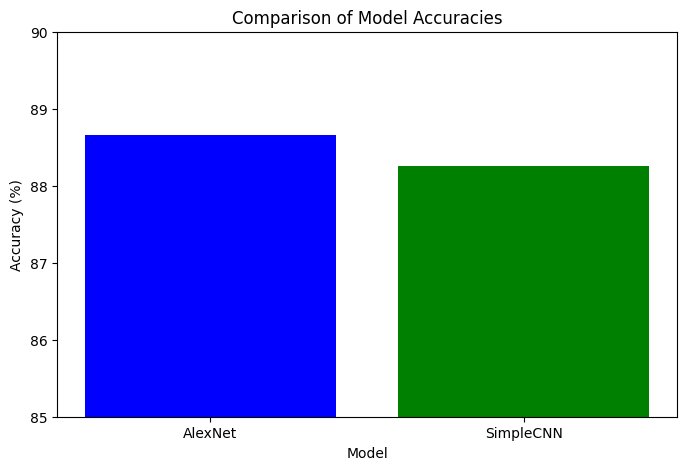

In [3]:
model_names = ['AlexNet', 'SimpleCNN']
accuracies = [88.66, 88.26]  # Example accuracies for both models

plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracies')
plt.ylim([85, 90])  # Set the limit to better highlight differences
plt.show()

## Discussion and Conclusion

### Key Findings
The performance comparison between AlexNet and SimpleCNN revealed that both models achieved similarly high accuracy, with AlexNet slightly edging out SimpleCNN by a marginal difference of 0.4%. This minimal variance suggests that SimpleCNN, despite its reduced complexity, is nearly as effective as the more sophisticated AlexNet for this specific task of melanoma detection.

### Implications
These findings challenge the conventional wisdom that more complex models always yield better results. In scenarios where computational resources or inference speed are constraints, SimpleCNN could be a viable alternative, providing nearly comparable accuracy to AlexNet with potentially lower resource usage.

### Future Directions
Given the tight performance metrics:
- **Efficiency Optimization**: Exploring methods to enhance the computational efficiency of AlexNet or further simplify SimpleCNN without sacrificing accuracy could be beneficial.
- **Ensemble Techniques**: Combining predictions from both models might leverage their strengths and improve overall accuracy.
- **Feature Engineering**: Investigating whether certain features or image preprocessing steps disproportionately benefit one model over the other could inform more targeted improvements.

In conclusion, this study highlights the importance of considering model architecture in relation to specific project needs, including computational demands and deployment environments. Balancing model complexity with operational practicalities remains key in deploying effective machine learning solutions in medical image analysis.


## DOI Citation

DOI (DIGITAL OBJECT IDENTIFIER)
10.34740/kaggle/dsv/3376422